In [42]:
import pandas as pd
import numpy as np

In [43]:
from sklearn.cluster import KMeans

In [44]:
def process_df(df, categories,category_sums, rename_cols = True):
    
    df = df.fillna(value='$$')
    
    if (rename_cols):
        df = df.rename(columns={"data/id": "id", "data/name": "name","data/category":"category","data/price_range":"price_range"})
    
    for i, row in df.iterrows():
        val = row['price_range']
        if val.find('$') < 0:
            df.at[i, 'price_range'] = 1
        else:
            df.at[i, 'price_range'] = len(val)

    for category in categories:
        category_sums[category] = len(df.loc[df['category'] == category])
        
    tensor_list = create_tensors(df, category_sums)

    return tensor_list

In [45]:
def create_tensors(df, category_sums):
    tensor = {k:0 for k,v in category_sums.items()}  
    for i in range(1, 5):
        tensor['$' + str(i)] = 0
    for i, row in df.iterrows():
        tensor['$' + str(row['price_range'])] += 1
        if row['category'] in tensor:
            tensor[row['category']] += 1
    
    return tensor.values()

In [46]:
def cluster_friends(user_id,categories,category_sums):
    friends_df = pd.read_csv('./all_friends.csv')
    friends_df = friends_df.fillna(value='$$')
    friend_ids = friends_df.user_id.unique()
    data_input = np.zeros((len(friend_ids), 54))
    index_user_id_map = []
    for i,friend_id in enumerate(friend_ids):
        temp_df = friends_df.loc[friends_df['user_id'] == friend_id]
        user_tensor_list = process_df(temp_df, categories,category_sums, rename_cols = False)
        index_user_id_map.append(friend_id)
        data_input[i] = list(user_tensor_list)
    kmeans = KMeans(n_clusters=4).fit(data_input)
    return kmeans,data_input,index_user_id_map

In [47]:
def get_closest_friends(my_id, index_user_id_map, kmeans, data_input, target_nodes = 4):
    # KnnNode class, storage class
    class KnnNode:
        def __init__(self,value,cluster_id,user_id):
            self.value = value
            self.cluster_id = cluster_id
            self.user_id = user_id

        def __str__(self):
            return str(self.value) + ", " + str(self.user_id)

    knnNodes = []

    # Map into object
    for friend_id in index_user_id_map:
        i = index_user_id_map.index(friend_id)
        knnNodes.append(KnnNode(kmeans.score([data_input[i]]),
                            kmeans.predict([data_input[i]]),
                            friend_id))

    # Sort by value
    knnNodes.sort(key=lambda x: x.value, reverse=True)
    
    max_range = -1 * knnNodes[-1].value

    start_index = 0 # index of my_id in the array knnNodes
    closest = [] # unpolished array of neighbours

    for i in range(0, len(knnNodes)):
        knnNode = knnNodes[i]
        # if my id is found, set it to that
        if str(knnNode.user_id) == my_id:
            start_index = i

    # keep track for efficient sorted array traversal
    left_index = start_index - 1
    right_index = start_index

    # will count up until target nodes
    count = 0

    while count < target_nodes:
        # will go right if possible and take the node
        if right_index < len(knnNodes):
            closest.append(knnNodes[right_index])
            right_index += 1
            count += 1
        # will go left if possible
        if left_index >= 0:
            closest.append(knnNodes[left_index])
            left_index -= 1
            count += 1

    inclusive_closest = []
    my_value = 0

    # closest but without my_id
    for close in closest:
        if str(close.user_id) != str(my_id):
            inclusive_closest.append(close)
        else:
            my_value = close.value
            
    # sort by best friends
    inclusive_closest.sort(key=lambda x: x.value, reverse=True) 

    return inclusive_closest, max_range, my_value

In [48]:
def get_events(my_id, event_type,index_user_id_map, all_df, kmeans, data_input):
    closest, max_range, my_value = get_closest_friends(my_id,index_user_id_map,kmeans, data_input)
    percentageSort = []

    for close in closest:
        percentageSort.append({
            'user_id': close.user_id,
            'value': 1 - abs(abs(my_value) - abs(close.value)) / max_range
        })

    percentageSort.sort(key=lambda x: x['value'], reverse=True) 

    events = []
    
    for userItem in percentageSort:
        userId = userItem['user_id']
        user_df = all_df.loc[all_df['user_id'] == userId]
        user_df = user_df.loc[user_df['category'].str.contains(event_type)]
        events += (list(user_df['name']))
        
    return events

In [49]:
def get_categories(user_id):
    
    main_df = pd.read_csv('./data.csv')
    
    main_df = main_df.fillna(value='$$')

    main_df = main_df.rename(columns={"data/id": "id", "data/name": "name","data/category":"category","data/price_range":"price_range"})

    categories = main_df.category.unique()
    category_sums = {}
    for category in categories:
            category_sums[category] = len(main_df.loc[main_df['category'] == category])
            
    return categories,category_sums

In [69]:
import random


In [84]:
def main_function(user_id):
    # Label categories
    categories,category_sums = get_categories(user_id)
    
    # Cluster friends
    kmeans,data_input,index_user_id_map = cluster_friends(user_id,categories,category_sums)
    
    print(len(data_input))
    data = data_input
    color = ['blue','black','black','black','red','green','green','green','black','red','red']
    
    x,y = indic(data)
    y = [random.uniform(0, 1) for i in range(11)]
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, marker='x', color = color)
    plt.show()

    # Get closest friends and get events
    all_df = pd.read_csv('./all_friends.csv')
    return get_events(user_id, 'Shop', index_user_id_map, all_df , kmeans , data_input)

11


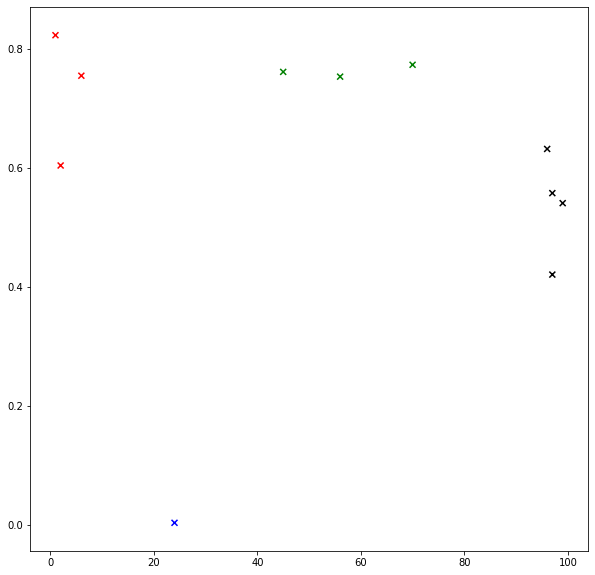

['Butter Avenue', "Arby's", 'Yutopia']

In [85]:
main_function('911762459191977')

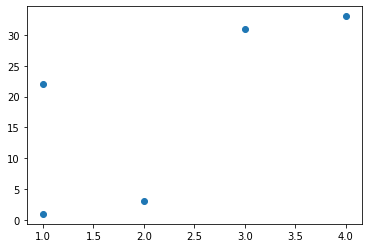

In [39]:
plt.scatter([1,3,4,1,2],[22,31,33,1,3])